First draft of comparative allele analysis between DK0911 and Pst_104E

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import os
import shutil
from Bio import SeqIO
from Bio import AlignIO
import distance
import editdistance
import math
import subprocess
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import collections
import pybedtools
from sklearn.externals.joblib import Parallel, delayed
import itertools as it

In [14]:
DK0911_fh = '/home/benjamin/genome_assembly/Warrior/allele_analysis/v04/post_analysis/DK_0911_v04_analysed_alleles.df'
Pst_104E_v12_fh = '/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/Warrior_comp_runs/allele_analysis/post_allele_analysis/Pst_104E_v12_analysed_alleles.df'

In [15]:
Pst_104E_df = pd.read_csv(Pst_104E_v12_fh, sep='\t')
DK0911_df = pd.read_csv(DK0911_fh, sep='\t')

/home/benjamin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [20]:
DK0911_df.columns

Index(['Query', 'Target', 'PctID', 'AlnLgth', 'NumMis', 'NumGap', 'StartQuery',
       'StopQuery', 'StartTarget', 'StopTarget', 'e-value', 'BitScore',
       'QLgth', 'QCov', 'TLgth', 'TCov', 'q_contig', 't_contig',
       'q_contig == t_contig', 't_contig == h_contig_overlap', 'allele_source',
       'matchType', 'aQuery', 'aTarget', 'comp', 'aQuery_LT', 'aTarget_LT',
       'Index', 'protein_hamming', 'protein_levenshtein', 'cds_hamming',
       'cds_levenshtein', 'yn00_dN/dS', 'LWL85_dN/dS', 'LWL85m_dN/dS',
       'LPB93_dN/dS', 'unphased_aQuery', 'PO_single_aQuery',
       'PO_single_aTarget', 'PO_interhaplotype_paralogs'],
      dtype='object')

In [21]:
DK0911_df.allele_source.unique()

array(['BLAST', 'PO', 'h_rBLAST', nan], dtype=object)

In [18]:
DK0911_df.drop('Unnamed: 0', axis=1, inplace=True)

In [19]:
Pst_104E_df.drop('Unnamed: 0', axis=1, inplace=True)

In [ ]:
allele_filter = ()

In [23]:
DK0911_alleles_df = DK0911_df[DK0911_df.allele_source.astype(str).str.contains('PO')]

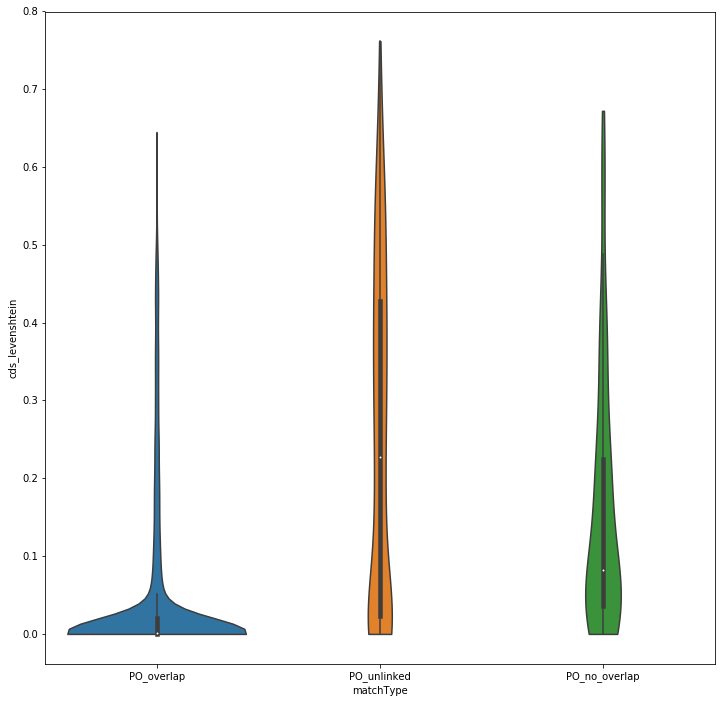

In [30]:
plt.figure(figsize=(12,12))
sns.violinplot(y='cds_levenshtein', x='matchType', data=DK0911_alleles_df, cut=0)

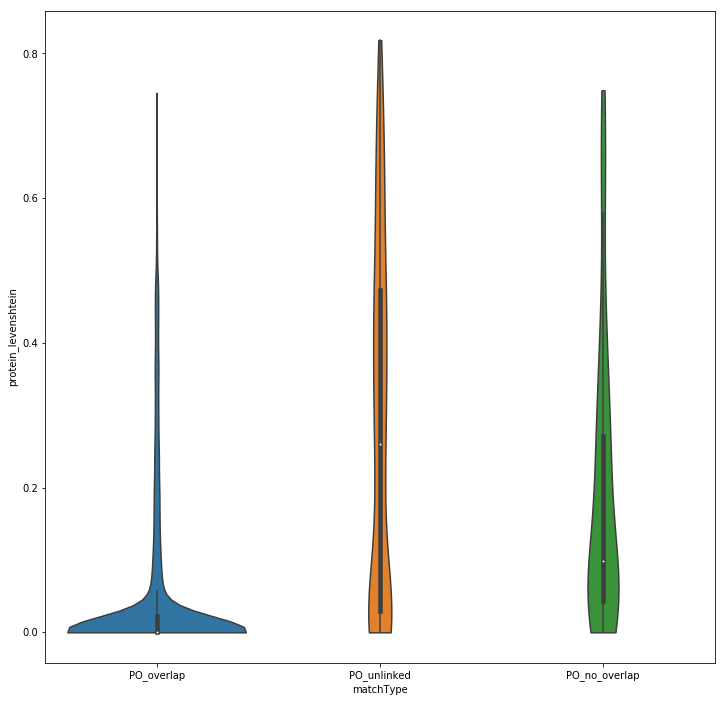

In [32]:
plt.figure(figsize=(12,12))
sns.violinplot(y='protein_levenshtein', x='matchType', data=DK0911_alleles_df, cut=0)

In [41]:
DK0911_allele_summary = DK0911_alleles_df.loc[:, [ 'protein_levenshtein', 
       'cds_levenshtein', 'yn00_dN/dS', 'LWL85_dN/dS' ]].describe().round(3)

In [38]:
Pst_104E_df_alleles_df = Pst_104E_df[Pst_104E_df.allele_source.astype(str).str.contains('PO')]

In [42]:
Pst_104E__allele_summary = Pst_104E_df_alleles_df.loc[:, [ 'protein_levenshtein', 
       'cds_levenshtein', 'yn00_dN/dS', 'LWL85_dN/dS' ]].describe().round(3)

In [43]:
Pst_104E__allele_summary 

,protein_levenshtein,cds_levenshtein,yn00_dN/dS,LWL85_dN/dS
count,11007.000,11007.000,6944.000,6973.000
mean,0.058,0.053,0.408,0.456
std,0.119,0.109,0.514,3.469
min,0.000,0.000,-0.000,0.000
25%,0.000,0.001,0.069,0.064
50%,0.007,0.007,0.260,0.210
75%,0.041,0.035,0.581,0.475
max,0.806,0.733,10.429,166.000


In [48]:
DK0911_allele_summary['protein_identity'] = (1 - DK0911_allele_summary.protein_levenshtein) * 100
DK0911_allele_summary['cds_identity'] = (1 - DK0911_allele_summary.cds_levenshtein) * 100
Pst_104E__allele_summary ['protein_identity'] = (1 - Pst_104E__allele_summary.protein_levenshtein) * 100
Pst_104E__allele_summary ['cds_identity'] = (1 - Pst_104E__allele_summary.cds_levenshtein) * 100

In [47]:
DK0911_allele_summary

,protein_levenshtein,cds_levenshtein,yn00_dN/dS,LWL85_dN/dS,protein_identity,cds_identity
count,8142.000,8142.000,3473.000,3483.000,-814100.0,-814100.0
mean,0.066,0.059,0.507,0.657,93.4,94.1
std,0.138,0.125,0.655,4.563,86.2,87.5
min,0.000,0.000,-0.000,0.000,100.0,100.0
25%,0.000,0.000,0.082,0.077,100.0,100.0
50%,0.002,0.002,0.400,0.291,99.8,99.8
75%,0.040,0.034,0.725,0.640,96.0,96.6
max,0.818,0.761,13.620,149.000,18.2,23.9


In [56]:
Pst_104E__allele_summary

,protein_levenshtein,cds_levenshtein,yn00_dN/dS,LWL85_dN/dS,protein_identity,cds_identity
count,11007.000,11007.000,6944.000,6973.000,-1100600.0,-1100600.0
mean,0.058,0.053,0.408,0.456,94.2,94.7
std,0.119,0.109,0.514,3.469,88.1,89.1
min,0.000,0.000,-0.000,0.000,100.0,100.0
25%,0.000,0.001,0.069,0.064,100.0,99.9
50%,0.007,0.007,0.260,0.210,99.3,99.3
75%,0.041,0.035,0.581,0.475,95.9,96.5
max,0.806,0.733,10.429,166.000,19.4,26.7


In [54]:
Merged_df = pd.concat([DK0911_alleles_df, Pst_104E_df_alleles_df], axis=0).reset_index(drop=True)

In [64]:
def strain(Query_LT):
    if 'DK0911' in Query_LT:
        return 'DK0911'
    elif 'Pst104E' in Query_LT:
        return 'Pst104E'

In [66]:
Merged_df['strain'] = Merged_df.aQuery_LT.apply(strain)

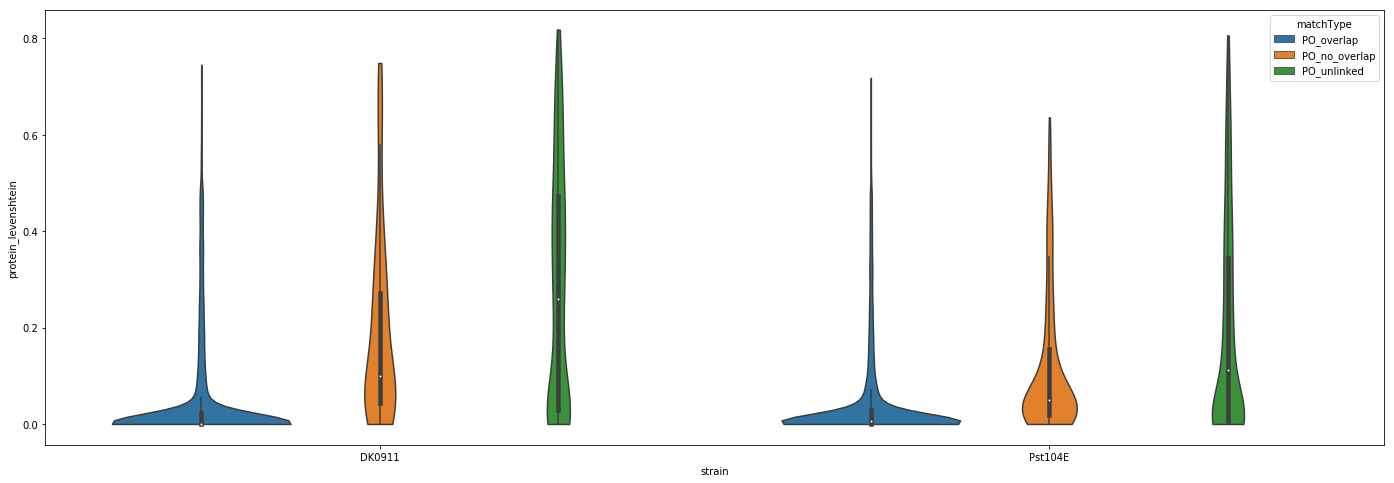

In [76]:
plt.figure(figsize=(24,8))
sns.violinplot(x='strain', y='protein_levenshtein', data=Merged_df, hue='matchType', \
               hue_order=['PO_overlap','PO_no_overlap', 'PO_unlinked' ] ,cut=0)

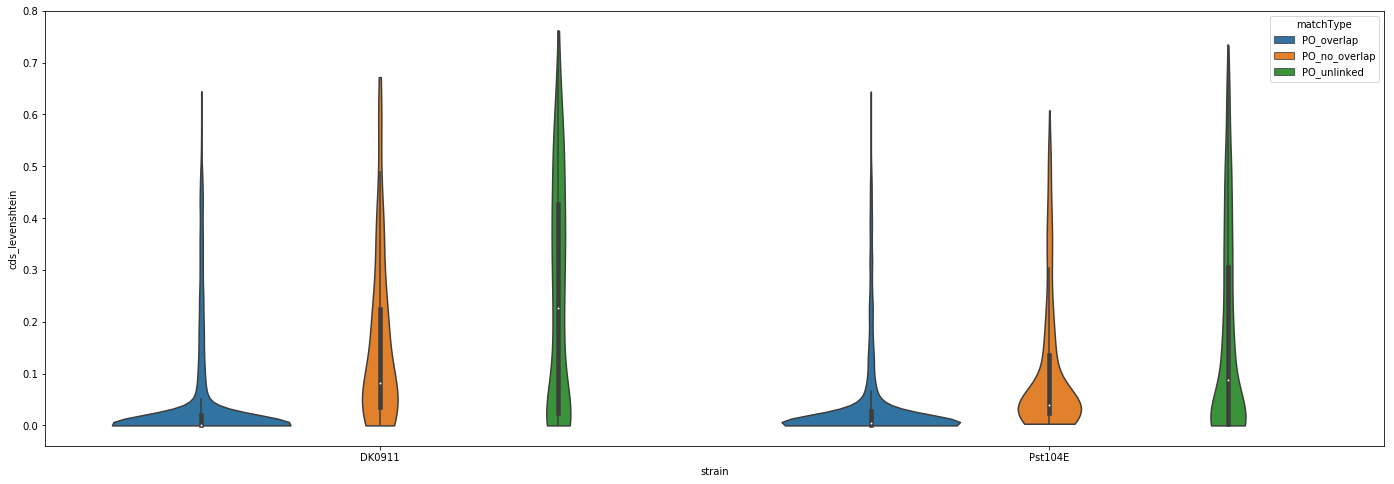

In [78]:
plt.figure(figsize=(24,8))
sns.violinplot(x='strain', y='cds_levenshtein', data=Merged_df, hue='matchType', \
               hue_order=['PO_overlap','PO_no_overlap', 'PO_unlinked' ] ,cut=0)

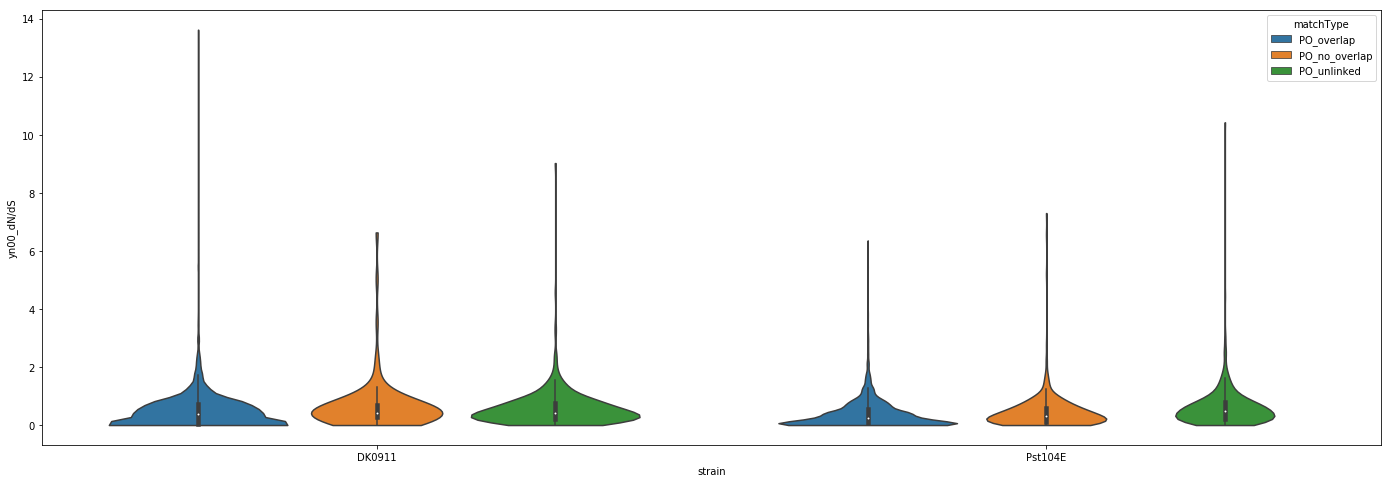

In [77]:
plt.figure(figsize=(24,8))
sns.violinplot(x='strain', y='yn00_dN/dS', data=Merged_df, hue='matchType', \
               hue_order=['PO_overlap','PO_no_overlap', 'PO_unlinked' ] ,cut=0)